# Get the names and indexes of the response genes.

In [40]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [41]:
response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])

In [42]:
data = pd.read_csv("/nfs/turbo/lsa-regier/scratch/roko/data/raw/merfish.csv")

In [43]:
data = data.drop(["Fos", "Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5"], axis=1)

In [44]:
data = data.iloc[:, 9:]

In [45]:
data.shape, data.columns # should start with "Ace2"

((1027848, 155),
 Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
        'Arhgap36', 'Avpr1a', 'Avpr2',
        ...
        'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
        'Vgf'],
       dtype='object', length=155))

In [46]:
response_indexes = [0,2,3,4,5,6,7,10,19,20,21,22,23,24,25,26,27,28,32,34,35,37,38,39,40,41,42,43,44,52,53,54,55,58,63,64,66,67,69,71,73,74,75,76,77,78,79,80,85,86,87,88,93,94,96,97,99,102,103,104,106,110,112,113,114,116,118,119,120,121,122,123,124,125,126,129,130,131,133,134,141,142,147,151]

In [47]:
IGNORANT_RADIUS = 0
AWARE_RADIUS = [5,10,15,20,25,30,35,40,45,50]

# Load the test losses for spatially ignorant baseline.

In [49]:
test_loss_rad_dict = {}

for rad in [IGNORANT_RADIUS]:
    with initialize(config_path="../config"):
        # try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 87)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "WITH_CELLTYPES")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", True)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
            test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        # except:
        #     try:
        #         OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
        #         print(cfg_from_terminal.training.filepath)
        #         output = test(cfg_from_terminal)
        #         trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
        #         test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        #     except:
        #         print(f"Model with radius of {rad} micrometers doesn't exist :(")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam.ckpt`
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.34988829493522644    │
│       test_loss_mse       │    0.34988829493522644    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  364            	

# Load the test losses for spatially aware model.

In [50]:
def calc_r2(truth, predictions):
    SS_res = torch.sum((truth - predictions)**2).item()
    SS_tot = torch.sum((truth - torch.mean(truth))**2).item()
    return 1 - SS_res/SS_tot

In [11]:
with open("0v60_w_celltypes.json", "r") as f:
    loss_dict = json.load(f)

In [51]:
r2_dict = {}
inputs_BASE_responses = inputs_BASE[:, response_indexes]

for rad in AWARE_RADIUS:
    with initialize(config_path="../config"):
        try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 87)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "WITH_CELLTYPES")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", True)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
            test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
        except:
            try:
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
                print(cfg_from_terminal.training.filepath)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
            except:
                print(f"Model with radius of {rad} micrometers doesn't exist :(")
    loss_dict[rad] = {}
    r2_dict[rad] = {}
    for i, gene in enumerate(response_genes):
        inputs_SPATIAL_responses = inputs_SPATIAL[:, response_indexes]
        current_gene = data.columns[response_indexes[i]]
        r2_dict[rad][current_gene] = {"base": calc_r2(inputs_BASE_responses[:, i], gene_expressions_BASE[:, i]), "spatial": calc_r2(inputs_SPATIAL_responses[:, i], gene_expressions_SPATIAL[:, i])}
        loss_dict[rad][current_gene] = {"base": torch.mean( (inputs_BASE_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
        loss_dict[rad][current_gene]["diff"] = loss_dict[rad][current_gene]["spatial"] - loss_dict[rad][current_gene]["base"]
        loss_dict[rad][current_gene]["percent_diff"] = (loss_dict[rad][current_gene]["diff"]/loss_dict[rad][current_gene]["base"]) * 100.0

MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:19<00:00,  1.21it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 25is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33311593532562256    │
│       test_loss_mse       │    0.33311593532562256    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  364            	

### Plot relationship between sparsity and spatial performance increase.

In [54]:
loss_dict

{25: {'Ace2': {'base': 0.14470702409744263,
   'spatial': 0.1420552283525467,
   'diff': -0.002651795744895935,
   'percent_diff': -1.8325273160964681,
   'sparsity': tensor(0.8469)},
  'Aldh1l1': {'base': 0.6029497981071472,
   'spatial': 0.5786845684051514,
   'diff': -0.02426522970199585,
   'percent_diff': -4.024419574925174,
   'sparsity': tensor(0.4772)},
  'Amigo2': {'base': 0.41306960582733154,
   'spatial': 0.4018978178501129,
   'diff': -0.011171787977218628,
   'percent_diff': -2.7045775868313537,
   'sparsity': tensor(0.5772)},
  'Ano3': {'base': 0.19442394375801086,
   'spatial': 0.1872323602437973,
   'diff': -0.007191583514213562,
   'percent_diff': -3.6989186492197392,
   'sparsity': tensor(0.7819)},
  'Aqp4': {'base': 0.7678506374359131,
   'spatial': 0.7073484063148499,
   'diff': -0.06050223112106323,
   'percent_diff': -7.879427087942337,
   'sparsity': tensor(0.4699)},
  'Ar': {'base': 0.5081300139427185,
   'spatial': 0.4852249324321747,
   'diff': -0.022905081510

Gene Name: Nnat, Percent Difference: -39.586556602483576%, Sparsity: 0.6385722160339355
Gene Name: Mbp, Percent Difference: -24.809951041867926%, Sparsity: 0.6638341546058655
Gene Name: Ebf3, Percent Difference: -13.711876649943264%, Sparsity: 0.8720905780792236
Gene Name: Sln, Percent Difference: -13.48004641759416%, Sparsity: 0.6145603656768799
Gene Name: Ermn, Percent Difference: -13.374139378647518%, Sparsity: 0.5715667605400085
Gene Name: Cd24a, Percent Difference: -11.721942490526368%, Sparsity: 0.5918209552764893
Gene Name: Greb1, Percent Difference: -11.653112485662993%, Sparsity: 0.8084632754325867
Gene Name: Myh11, Percent Difference: -11.557441503739367%, Sparsity: 0.8398342132568359
Gene Name: Sgk1, Percent Difference: -10.892061424434022%, Sparsity: 0.4381808340549469
Gene Name: Gda, Percent Difference: -10.512721889619849%, Sparsity: 0.5832341313362122
Gene Name: Ndrg1, Percent Difference: -9.978457986150216%, Sparsity: 0.2859247624874115
Gene Name: Irs4, Percent Differen

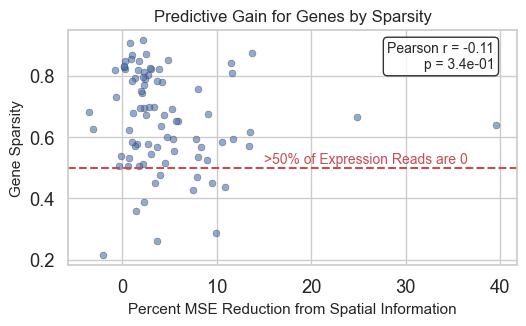

: 

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# First, let's sort the genes based on their percent differences in descending order (largest decrease first)
sorted_genes = sorted(loss_dict[25], key=lambda gene: -loss_dict[25][gene]["percent_diff"], reverse=True)

# Now, iterate through each gene in the sorted order
for gene in sorted_genes:
    # Extract percent difference and sparsity for each gene
    percent_diff = loss_dict[25][gene]["percent_diff"]
    sparsity = loss_dict[25][gene]["sparsity"]
    
    # Print the gene name, percent difference, and sparsity in descending order of percent difference
    print(f"Gene Name: {gene}, Percent Difference: {percent_diff}%, Sparsity: {sparsity}")


# Extract percent differences and sparsity for each gene
percent_diffs = np.array([-loss_dict[25][gene]["percent_diff"] for gene in sorted_genes])
sparsities = np.array([loss_dict[25][gene]["sparsity"] for gene in sorted_genes])

# Compute Pearson correlation
corr, pval = pearsonr(percent_diffs, sparsities)

# Create plot
sns.set(style="whitegrid", font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5, 3.5))
scatter = ax.scatter(percent_diffs, sparsities, alpha=0.6, edgecolor='k', linewidth=0.3, s=25)

# Add horizontal line at y=0.5
ax.axhline(y=0.5, color='r', linestyle='--')

# Add caption for the horizontal line
ax.text(15, 0.55, ">50% of Expression Reads are 0", fontsize=10, color='r', verticalalignment='top')

# Axis labels and title
ax.set_title("Predictive Gain for Genes by Sparsity", fontsize=12)
ax.set_xlabel("Percent MSE Reduction from Spatial Information", fontsize=11)
ax.set_ylabel("Gene Sparsity", fontsize=11)

# Add correlation in a box
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8)
ax.text(0.95, 0.95,
        f"Pearson r = {corr:.2f}\np = {pval:.1e}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=bbox_props)

plt.tight_layout()
plt.savefig('sparsity_scatter_MERFISH.png')
plt.show()


# Get the losses for each response gene in both cases.

In [13]:
# loss_dict

In [14]:
with open("0v60_w_celltypes.json", "w") as file:
    json.dump(loss_dict, file)

In [15]:
# r2_dict

In [16]:
with open("r2_0v60_w_celltypes.json", "w") as file:
    json.dump(r2_dict, file)

# Plot the results.

In [17]:
import matplotlib.pyplot as plt

In [18]:
percent_differences = [-loss_dict["25"][x]["percent_diff"] for x in loss_dict["25"]]

In [ ]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% loss reduction in spatial model relative to baseline")
plt.xlabel("Percent Reduction in Test Loss")
plt.show()

# Annotated Plot

In [ ]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% Loss reduction in spatial model relative to baseline.")
plt.xlabel("Percent Reduction in Test Loss")
plt.annotate("Nnat", xy=(39.5866-2, 1.25))
plt.annotate("Mbp", xy=(24.8099-1.3, 1.25))
plt.savefig("0VSspatial.png", dpi=300)
plt.show()

# Heatmap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with open("0v60_w_celltypes.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(25, -1, -5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
]).T

# Set the figure size based on the dimensions of your data
cell_width = 0.5
cell_height = 2.5
fig, ax = plt.subplots(figsize=(cell_width*len(genes), cell_height*len(radius_values)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.005)
cbar.ax.set_ylabel("Loss values", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(genes)))
ax.set_xticklabels(genes)
ax.set_yticks(np.arange(len(radius_values)))
ax.set_yticklabels(list(radius_values))


# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(radius_values)):
    for j in range(len(genes)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=8)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_horizontal_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60_w_celltypes.json", "r") as file:
    loss_dict = json.load(file)

fig, axes = plt.subplots(2, 2, figsize=(12,18))

quarter = 0

full_loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
]).T

for ax in axes.ravel():
    
    quarter += 1
    radius_values = list(range(0, 26, 5))
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] for i in range(n * (quarter - 1) // 4, n * quarter // 4)]
    
    loss_array = np.array([
        [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
    ])

    # Set the figure size based on the dimensions of your data
    cell_width = 2.5
    cell_height = 0.5
    
    im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(full_loss_array)), vmax=np.max(np.abs(full_loss_array)))
    
    # Add a colorbar for reference with adjusted fraction to make it thinner
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
    cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes)
    
    # Adjust font size
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjust text color based on cell value and format the number to 2 decimal places
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            if loss_array[i, j] < 0:  # If value is negative, use white text
                text_color = 'red'
            else:  # Otherwise, use black text
                text_color = 'green'
            text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                           ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_vertical_full_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60_w_celltypes.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 20
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60_w_celltypes.json", "r") as file:
    r2_dict = json.load(file)

fig, axes = plt.subplots(2, 2, figsize=(12,18))

quarter = 0

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

full_r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

for ax in axes.ravel():
    
    quarter += 1
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] for i in range(n * (quarter - 1) // 4, n * quarter // 4)]
    
    r2_array = np.array([
        [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
    ])

    # Set the figure size based on the dimensions of your data
    cell_width = 2.5
    cell_height = 0.5
    
    im = ax.imshow(r2_array, cmap='coolwarm', vmin=0, vmax=1)
    
    # Add a colorbar for reference with adjusted fraction to make it thinner
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
    cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes)
    
    # Adjust font size
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjust text color based on cell value and format the number to 2 decimal places
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
                text_color = 'red'
            else:  # Otherwise, use black text
                text_color = 'white'
            text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                           ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_vertical_r2_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60_w_celltypes.json", "r") as file:
    r2_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="coolwarm")
# im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="PiYG")

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'white'
        text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_r2_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60_w_celltypes.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 0.03
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT_w_celltypes.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60_w_celltypes.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
# THRESHOLD_ABS = 0.03
# THRESHOLD_MIN = 0
# genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
# loss_array = np.array([
#     [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
# ])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$MSE_{r} - MSE_{0}$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT_full_w_celltypes.png", dpi=600)
plt.show()